In [1]:
%matplotlib inline

import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from livelossplot import PlotLossesKerasTF
from livelossplot.outputs import MatplotlibPlot
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import util
import time
import os

In [2]:
#tf.debugging.set_log_device_placement(True)
# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

print(tf.test.is_built_with_cuda())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)
True
Num GPUs Available:  1


In [3]:
folder_path = '../../datasets/kaggle_comp/split_files/'
train_file = 'train.csv'
valid_file = 'valid.csv'
test_file = 'test.csv'
save_file = 'test_pred.csv'
train=pd.read_csv(folder_path+train_file, header=0)
train.fillna(value='', inplace=True)
train_X,train_Y=(np.array(train["text"]), np.array(train["label"]))

valid=pd.read_csv(folder_path+valid_file, header=0)
valid.fillna(value='', inplace=True)
valid_X,valid_Y=(np.array(valid["text"]),np.array(valid["label"]))

test=pd.read_csv(folder_path+test_file, header=0)
test.fillna(value='', inplace=True)
test_X,test_Y=(np.array(test["text"]),np.array(test["label"]))

In [4]:
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=1000000)
encoder.adapt(train_X)

/opt/conda/envs/fakenews/lib/python3.7/site-packages/tensorflow/python/keras/layers/preprocessing/text_vectorization.py:338: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(preprocessed_data.to_list())


In [5]:
model=tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary())+1000,
        output_dim=64),
    tf.keras.layers.Masking(mask_value=0),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [6]:
def plot_export(ax, gr, label):
    blue=mpatches.Patch(color='blue', label="Training")
    orange=mpatches.Patch(color='orange', label="Validation")
    plt.legend(handles=[blue,orange])
    plt.savefig("plots/rnn_comp_plot.jpg")

plotlosses = PlotLossesKerasTF(outputs=[MatplotlibPlot(after_subplot=plot_export)])
checkpoint_path = "training_checkpoints/comp/rnn_cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

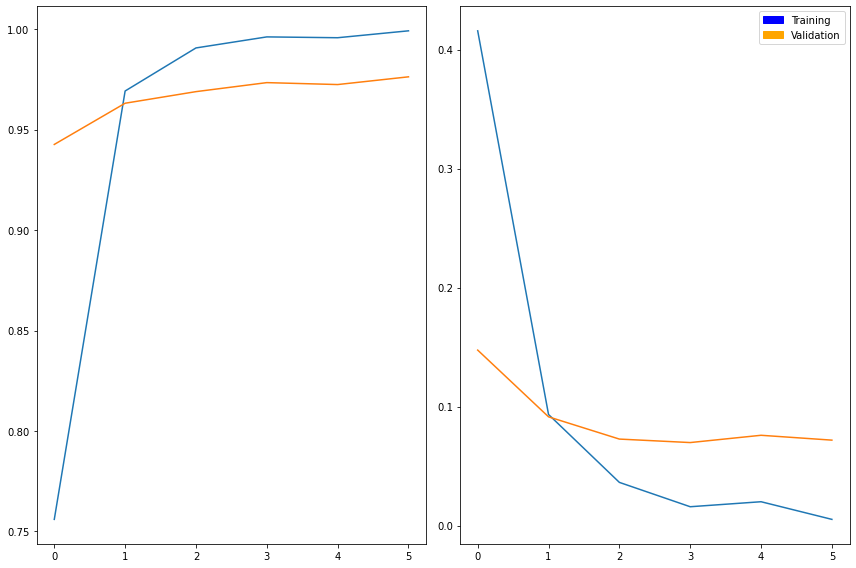

455/455 [==============================] - 183s 402ms/step - loss: 0.0052 - accuracy: 0.9992 - val_loss: 0.0718 - val_accuracy: 0.9763
Execution time: 1139.3724765777588 ms


In [7]:
start_time = time.time()
history=model.fit(train_X,train_Y,epochs=6,validation_data=(valid_X,valid_Y),callbacks=[cp_callback,plotlosses],verbose=True, workers=1)
print("Execution time: " + str((time.time() - start_time)) + ' ms')

In [8]:
#model.load_weights(checkpoint_path)

In [9]:
test_loss, test_acc = model.evaluate(test_X, test_Y, workers=1)
str=""
str+='Test Loss: {}'.format(test_loss)
str+='\nTest Accuracy: {}'.format(test_acc)

util.writeText("RNN_comp_report\n"+str, "rnn_comp_report.txt")

98/98 [==============================] - 13s 135ms/step - loss: 0.0717 - accuracy: 0.9763
